In [1]:
# Cell 1: Setup and Imports
# This cell imports all necessary libraries and configures the environment for
# both regression and classification evaluation.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules for model selection, preprocessing, and evaluation.
# KFold is included for regression specific cross-validation.
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor # Specifically imported for regression tasks
from sklearn.preprocessing import StandardScaler

# All necessary metrics for both regression and classification evaluations are imported.
from sklearn.metrics import (
    # Regression Metrics:
    r2_score,           # R-squared (coefficient of determination)
    mean_squared_error, # Mean Squared Error
    mean_absolute_error, # Mean Absolute Error

    # Classification Metrics (used for binarized regression predictions):
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)
import joblib # For saving and loading Python objects, especially scikit-learn models
import os     # For interacting with the operating system (e.g., creating directories)
import json   # For handling JSON data (e.g., saving experiment configurations)

# --- Custom Imports ---
# Ensure 'utils.py' is in the same directory or accessible via your Python path.
from utils import load_and_format_data, pick_scaler

# Configure matplotlib and seaborn for consistent and aesthetically pleasing plots.
plt.style.use('ggplot')       # Apply the 'ggplot' style to matplotlib plots
sns.set_palette("viridis")    # Set the default color palette for seaborn plots

# Initialize an empty list to store results from different experimental scenarios.
experiment_results = []

print("Cell 1: Setup and Imports complete for REGRESSION + CLASSIFICATION EVALUATION.")

Cell 1: Setup and Imports complete for REGRESSION + CLASSIFICATION EVALUATION.


In [ ]:
# Cell 2: Main Configuration
# This cell defines global constants and configuration parameters for the entire
# regression workflow, including parameters for subsequent classification evaluation.

# --- Data Paths and Column Names ---
# Path to the main CSV data file.
DATA_CSV_PATH = "/Users/cyriltelley/Desktop/MSE/Second_semester/PA-MReye/Codes/MREyeQC_PA/data/IQA.csv"
SAMPLE_ID_COLUMN = "sub"  # Column containing unique sample/subject IDs.
FIRST_IQM_COLUMN_NAME = "centroid"  # The name of the first Image Quality Metric (IQM) column.
# MODIFIED: The 'rating' column is now designated as our continuous target variable for regression.
CONTINUOUS_RATING_COLUMN = "rating"

# --- Model Selection ---
# MODIFIED: The chosen model is now a Regressor.
MODEL_CHOICE = 'RandomForestRegressor'

# --- NEW: Threshold for Classification Evaluation ---
# This threshold is crucial for evaluating the regression model's performance
# as if it were a classifier. Regression predictions will be binarized based on this.
# Any prediction less than or equal to this value will be considered "Rejected" (class 1).
EVALUATION_THRESHOLD = 2.1

# --- Cross-Validation and Feature Selection Parameters ---
GROUP_COLUMN_FOR_CV = None  # Column to use for GroupKFold cross-validation (set to None if not used).
# EXCLUDED_IQMS_FROM_TRAIN_X: List of IQM features to explicitly exclude from training.
# Currently set to include all features (empty string effectively means no exclusion).
EXCLUDED_IQMS_FROM_TRAIN_X = [""]
SCALER_CHOICE = 'StandardScaler'  # Type of scaler to use for feature scaling (e.g., 'StandardScaler').
TEST_SET_SIZE = 0.3  # Proportion of data to be used for the test set.
RANDOM_STATE = 42    # Seed for reproducibility of random processes.

# --- Output Directory ---
# Directory to save trained models, scalers, feature lists, and configuration.
# This path is updated to reflect that regression models are being saved.
MODEL_OUTPUT_DIR = "./trained_models_MREye_REGRESSION"
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)  # Create the directory if it doesn't already exist.

# --- Correlation-based Feature Selection Parameters ---
APPLY_CORRELATION_FEATURE_SELECTION = False  # Flag to apply correlation-based feature removal.
CORRELATION_THRESHOLD = 0.9  # Threshold for removing highly correlated features.

print("Cell 3: Main Configuration complete for REGRESSION.")
print(f"Evaluation threshold for classification metrics set to: {EVALUATION_THRESHOLD}")

Cell 3: Main Configuration complete for REGRESSION.
Evaluation threshold for classification metrics set to: 2.1


In [3]:
# Cell 3: Scenario Definition
# This cell defines a specific experimental scenario by setting its parameters.
# This allows for easy switching between different configurations for testing.

# --- Scenario Identification ---
scenario_name = "Scenrario 2 THRESHOLD = 2.0"

# --- Data Filtering Parameters ---
# Optional: List of subject IDs to include in the analysis.
# Set to `None` to include all subjects present in the dataset.
SUBJECT_ID_FILTER_LIST = None
# SUBJECT_ID_FILTER_LIST = list(range(1, 84)) # Example: to include subjects 1 to 83

# --- Feature Selection Parameters ---
# Flag to enable or disable correlation-based feature removal for this specific scenario.
APPLY_CORRELATION_FEATURE_SELECTION = False # Set to True to enable correlation filtering

# --- Scenario Summary Output ---
# Prints the chosen parameters for the current scenario for clarity.
print(f"--- STARTING REGRESSION SCENARIO: {scenario_name} ---")
print(f"   Subject Filter: {'All Subjects' if SUBJECT_ID_FILTER_LIST is None else f'Subject Subset'}")
print(f"   Apply Correlation Feature Selection: {APPLY_CORRELATION_FEATURE_SELECTION}")

--- STARTING REGRESSION SCENARIO: Scenrario 2 THRESHOLD = 2.0 ---
   Subject Filter: All Subjects
   Apply Correlation Feature Selection: False


In [4]:
# Cell 4: Data Loading, Filtering, and Initial Preparation
# This cell handles loading the raw data, filtering it based on the defined scenario,
# and preparing it for further preprocessing.

# Initialize empty DataFrames to store processed data components.
df_processed_data_full = pd.DataFrame() # Stores the full dataset after initial loading
features_df = pd.DataFrame()           # Stores only the IQM features
metadata_df = pd.DataFrame()           # Stores metadata (like subject IDs, ratings)
df_scenario_data = pd.DataFrame()      # Stores data specific to the current scenario

# Load and format the data using the custom utility function 'load_and_format_data'.
# This function is expected to separate IQM features from other metadata.
features_df, metadata_df = load_and_format_data(DATA_CSV_PATH, FIRST_IQM_COLUMN_NAME)

# Concatenate features and metadata into a single DataFrame if both are successfully loaded
# and have the same number of rows (indicating a proper merge is possible).
if not features_df.empty and not metadata_df.empty and len(features_df) == len(metadata_df):
    df_processed_data_full = pd.concat([metadata_df, features_df], axis=1)

# --- Debugging Subject IDs (Optional but recommended for data verification) ---
# This block helps verify that subject IDs are correctly loaded and their data types.
if not df_processed_data_full.empty and SAMPLE_ID_COLUMN in df_processed_data_full.columns:
    print(f"\n--- Debugging Subject IDs ---")
    print(f"First 5 unique values in '{SAMPLE_ID_COLUMN}': {df_processed_data_full[SAMPLE_ID_COLUMN].unique()[:5]}")
    print(f"Data type of '{SAMPLE_ID_COLUMN}': {df_processed_data_full[SAMPLE_ID_COLUMN].dtype}")
    print(f"First 5 values in your SUBJECT_ID_FILTER_LIST: {SUBJECT_ID_FILTER_LIST[:5] if SUBJECT_ID_FILTER_LIST else 'None'}")
    if SUBJECT_ID_FILTER_LIST:
        print(f"Data type of elements in SUBJECT_ID_FILTER_LIST (first element): {type(SUBJECT_ID_FILTER_LIST[0])}")
    print(f"--- End Debugging Subject IDs ---\n")

# --- Apply Subject ID Filtering ---
# Filter the data based on the 'SUBJECT_ID_FILTER_LIST' defined in the scenario.
if not df_processed_data_full.empty:
    if SUBJECT_ID_FILTER_LIST is not None and SAMPLE_ID_COLUMN in df_processed_data_full.columns:
        df_scenario_data = df_processed_data_full[
            df_processed_data_full[SAMPLE_ID_COLUMN].isin(SUBJECT_ID_FILTER_LIST)
        ].copy()
    else:
        # If no subject filter is specified, use the entire loaded dataset.
        df_scenario_data = df_processed_data_full.copy()

    # --- Prepare Continuous Rating Column ---
    # Ensure the continuous rating column is numeric and handle missing values.
    if not df_scenario_data.empty:
        df_scenario_data[CONTINUOUS_RATING_COLUMN] = pd.to_numeric(
            df_scenario_data[CONTINUOUS_RATING_COLUMN], errors='coerce' # Convert to numeric, set invalid parsing as NaN
        )
        df_scenario_data.dropna(subset=[CONTINUOUS_RATING_COLUMN], inplace=True) # Remove rows with NaN in the rating column

print("Cell 3 (now 4): Load and Filter Data complete.")
print(f"   df_scenario_data shape for '{scenario_name}': {df_scenario_data.shape}")

Removed 1 rows due to NaN values in IQM features.

--- Debugging Subject IDs ---
First 5 unique values in 'sub': [1 2 3 4 5]
Data type of 'sub': int64
First 5 values in your SUBJECT_ID_FILTER_LIST: None
--- End Debugging Subject IDs ---

Cell 3 (now 4): Load and Filter Data complete.
   df_scenario_data shape for 'Scenrario 2 THRESHOLD = 2.0': (167, 193)


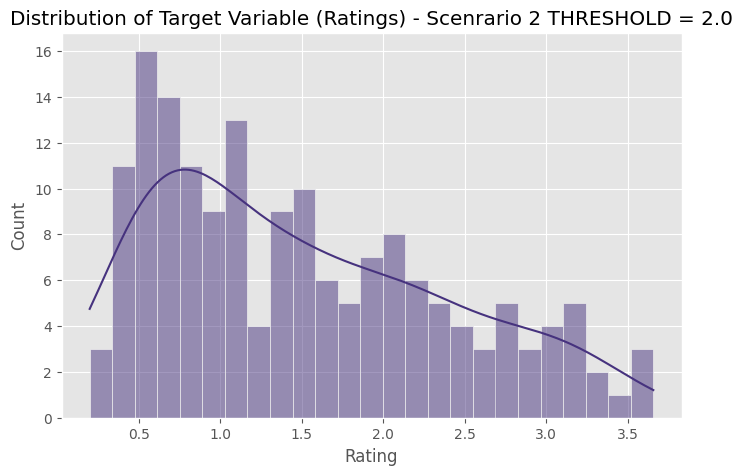


--- Correlation Matrix of All Candidate IQM Features (185 features) ---


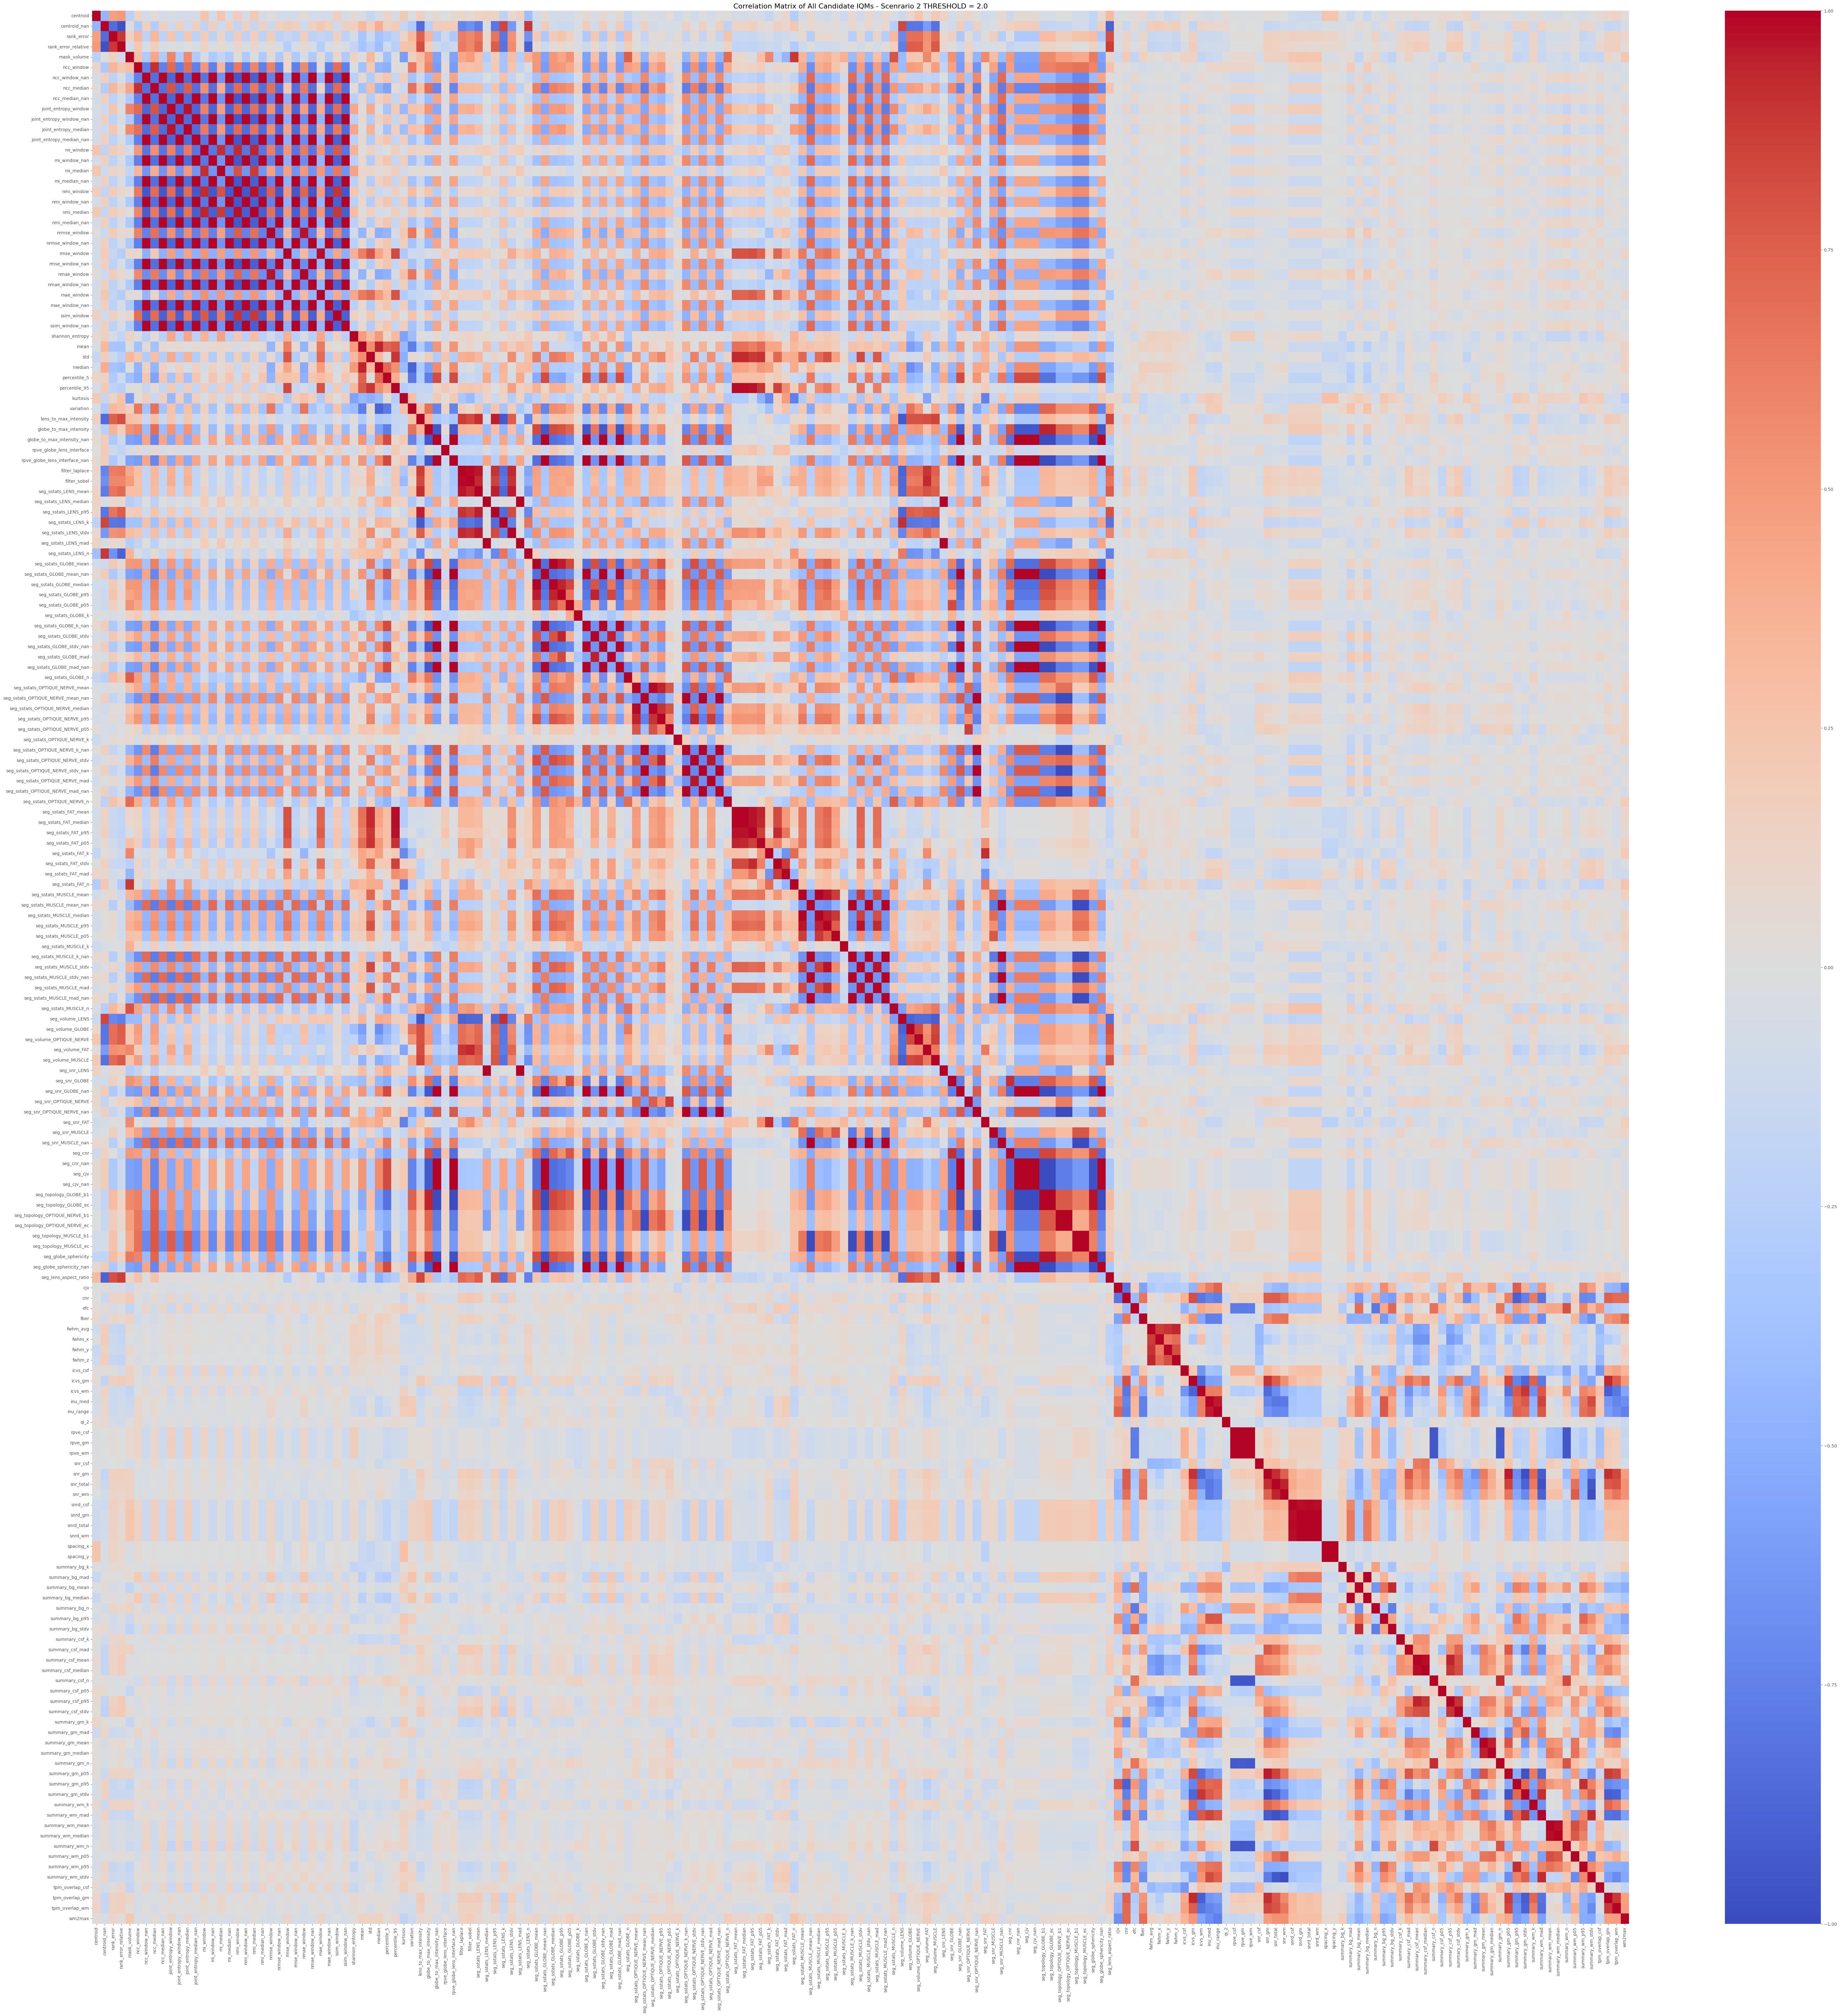

Initial number of features before any selection: 185
Cell 6: Preprocessing for Scenrario 2 THRESHOLD = 2.0 complete.


In [5]:
# Cell 5: Data Visualization, Target Creation, Preprocessing, and Splitting
# This cell prepares the feature matrix (X) and target vector (y), handles
# feature selection (correlation-based), scales features, and splits the data.

# Initialize empty DataFrames and variables for the training and testing sets.
X_train, X_test = pd.DataFrame(), pd.DataFrame()
y_train, y_test = None, None
X_train_scaled, X_test_scaled = None, None
numeric_features_final = [] # This list will hold the names of features used for training
scaler_obj = None           # Object to hold the fitted scaler (e.g., StandardScaler)
y = None                    # Our continuous target variable for regression

# Proceed only if the scenario data is not empty and the continuous rating column exists.
if not df_scenario_data.empty and CONTINUOUS_RATING_COLUMN in df_scenario_data.columns:
    # MODIFIED: The target 'y' is now directly the continuous rating column.
    y = df_scenario_data[CONTINUOUS_RATING_COLUMN].copy()

    # --- Visualize the Distribution of the Continuous Target Variable ---
    # This histogram helps understand the spread and characteristics of the ratings.
    plt.figure(figsize=(8, 5))
    sns.histplot(y, kde=True, bins=25)
    plt.title(f'Distribution of Target Variable (Ratings) - {scenario_name}')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.show()

    # --- Prepare Candidate Features (IQMs) ---
    # Identify IQM columns from the full 'features_df' that are present in the current 'df_scenario_data'.
    existing_feature_cols = [col for col in features_df.columns if col in df_scenario_data.columns]
    X_candidate_features = df_scenario_data[existing_feature_cols].copy()

    if not X_candidate_features.empty:
        # --- Visualize Correlation Matrix of All Candidate Features ---
        # This heatmap helps identify highly correlated features before selection.
        print(f"\n--- Correlation Matrix of All Candidate IQM Features ({X_candidate_features.shape[1]} features) ---")
        n_features_all = X_candidate_features.shape[1]
        fig_width_all = max(12, n_features_all * 0.35)  # Dynamically adjust figure size
        fig_height_all = max(10, n_features_all * 0.35) # Dynamically adjust figure size
        corr_matrix_all = X_candidate_features.corr()
        plt.figure(figsize=(fig_width_all, fig_height_all))
        sns.heatmap(corr_matrix_all, annot=False, cmap='coolwarm', fmt=".1f")
        plt.title(f'Correlation Matrix of All Candidate IQMs - {scenario_name}', fontsize=16)
        plt.tight_layout(pad=3.0) # Adjust layout to prevent labels from overlapping
        plt.show()

        # Initial feature set (X) is all candidate features, possibly excluding predefined ones.
        # 'errors='ignore'' prevents errors if a column in EXCLUDED_IQMS_FROM_TRAIN_X is not found.
        X = X_candidate_features.drop(columns=EXCLUDED_IQMS_FROM_TRAIN_X, errors='ignore') if EXCLUDED_IQMS_FROM_TRAIN_X and EXCLUDED_IQMS_FROM_TRAIN_X[0] != "" else X_candidate_features.copy()
        print(f"Initial number of features before any selection: {X.shape[1]}")

        # --- Apply Correlation-based Feature Selection (if enabled for the scenario) ---
        if APPLY_CORRELATION_FEATURE_SELECTION:
            print(f"\nApplying correlation-based feature selection for {scenario_name} (Threshold: {CORRELATION_THRESHOLD})...")
            corr_matrix_X = X.corr().abs() # Calculate the absolute correlation matrix.

            # Select the upper triangle of the correlation matrix to avoid redundant pairs and self-correlations.
            upper = corr_matrix_X.where(np.triu(np.ones(corr_matrix_X.shape), k=1).astype(bool))

            # Identify features to drop: if any feature in a pair has a correlation above the threshold, one is dropped.
            to_drop = {column for column in upper.columns if any(upper[column] > CORRELATION_THRESHOLD)}
            print(f"   Features to drop due to high correlation: {list(to_drop)}")
            X = X.drop(columns=list(to_drop), errors='ignore') # Drop the identified features.
            print(f"   Number of features after correlation-based selection: {X.shape[1]}")

            # --- Visualize Correlation Matrix After Feature Selection ---
            if not X.empty:
                print(f"\n--- Correlation Matrix After Feature Selection ({X.shape[1]} features) ---")
                n_features_selected = X.shape[1]
                fig_width_selected = max(10, n_features_selected * 0.35)
                fig_height_selected = max(8, n_features_selected * 0.35)
                corr_matrix_selected = X.corr()
                plt.figure(figsize=(fig_width_selected, fig_height_selected))
                sns.heatmap(corr_matrix_selected, annot=False, cmap='coolwarm', fmt=".1f")
                plt.title(f'Correlation Matrix After Selection - {scenario_name}', fontsize=14)
                plt.tight_layout(pad=3.0)
                plt.show()
            else:
                print("   WARNING: All features dropped after correlation selection. Check threshold or data.")

        # Store the final list of numeric features that will be used for training.
        numeric_features_final = X.columns.tolist()

        if not X.empty and not y.empty:
            X.fillna(0, inplace=True) # Impute any remaining NaN values with 0. Consider other imputation strategies.

            # --- Split Data into Training and Test Sets ---
            # MODIFIED: For regression, 'stratify=y' is typically not used, as it's for classification.
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=TEST_SET_SIZE, random_state=RANDOM_STATE
            )

            # --- Feature Scaling ---
            scaler_obj = pick_scaler(SCALER_CHOICE) # Get the chosen scaler object (e.g., StandardScaler).
            if scaler_obj is not None:
                # Fit the scaler on the training data and transform both training and test data.
                X_train_scaled_np = scaler_obj.fit_transform(X_train)
                X_test_scaled_np = scaler_obj.transform(X_test)
                # Convert scaled NumPy arrays back to Pandas DataFrames, preserving column names and indices.
                X_train_scaled = pd.DataFrame(X_train_scaled_np, columns=numeric_features_final, index=X_train.index)
                X_test_scaled = pd.DataFrame(X_test_scaled_np, columns=numeric_features_final, index=X_test.index)
            else:
                # If no scaler is chosen, use the original (unscaled) DataFrames.
                X_train_scaled = X_train.copy()
                X_test_scaled = X_test.copy()
        else:
            print(f"   WARNING: X or y is empty after feature selection/target preparation for {scenario_name}. Model training will be skipped.")
            X_train_scaled = pd.DataFrame() # Ensure empty DataFrame to prevent downstream errors
            X_test_scaled = pd.DataFrame()   # Ensure empty DataFrame to prevent downstream errors


print(f"Cell 6: Preprocessing for {scenario_name} complete.")
# Additional check for empty scaled data to inform about skipped training
if X_train_scaled is None or X_train_scaled.empty:
    print(f"   WARNING: X_train_scaled is empty or None for {scenario_name}. Model training will likely be skipped.")

In [6]:
# Cell 6: Model Training
# This cell sets up the cross-validation strategy, defines the regression model
# and its hyperparameters, and performs hyperparameter tuning using GridSearchCV.

best_model = None  # Initialize the variable to store the best trained model.
grid_search = None # Initialize the GridSearchCV object.

# Proceed with model training only if scaled training data and target variable are available.
if X_train_scaled is not None and y_train is not None and not X_train_scaled.empty:
    # --- Define Cross-Validation Splitter ---
    # MODIFIED: KFold is the standard cross-validation strategy for regression tasks.
    # StratifiedKFold is typically used for classification to preserve class proportions.
    cv_splitter = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    print(f"Using CV Splitter for {scenario_name}: {type(cv_splitter).__name__}")

    model_instance = None # Initialize the model estimator.
    param_grid = {}       # Initialize the dictionary for hyperparameters to search.

    # --- Model Selection and Hyperparameter Grid Definition ---
    if MODEL_CHOICE == 'RandomForestRegressor':
        # MODIFIED: Instantiate RandomForestRegressor for regression tasks.
        # 'random_state' ensures reproducibility.
        model_instance = RandomForestRegressor(random_state=RANDOM_STATE)
        # Hyperparameters for RandomForestRegressor.
        param_grid = {
            'n_estimators': [50, 100, 200],      # Number of trees in the forest.
            'max_depth': [None, 10, 20],        # Maximum depth of each tree (None means unlimited).
            'min_samples_split': [5, 10, 20],    # Minimum number of samples required to split an internal node.
            'min_samples_leaf': [1, 4, 8]       # Minimum number of samples required to be at a leaf node.
        }
    else:
        print(f"ERROR: MODEL_CHOICE '{MODEL_CHOICE}' is not configured for regression.")

    # --- Perform GridSearchCV for Hyperparameter Tuning ---
    if model_instance is not None and param_grid:
        # GridSearchCV exhaustively searches over the specified parameter values for the estimator.
        # MODIFIED: The scoring metric is changed to 'r2' (R-squared) for regression.
        # 'n_jobs=-1' utilizes all available CPU cores for faster computation.
        # 'verbose=1' provides feedback during the grid search process.
        grid_search = GridSearchCV(estimator=model_instance, param_grid=param_grid,
                                   cv=cv_splitter, scoring='r2',
                                   n_jobs=-1, verbose=1)

        # Fit GridSearchCV to the scaled training data and corresponding continuous target.
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_ # Retrieve the best estimator found by GridSearchCV.
    else:
        print(f"Model instance or param_grid not set for {MODEL_CHOICE}. Skipping GridSearchCV.")

print(f"Cell 7: Model Training for {scenario_name} complete.")
if best_model is not None and grid_search is not None:
    print(f"   Best model parameters: {grid_search.best_params_}")
    print(f"   Best CV R-squared (R2) score: {grid_search.best_score_:.4f}")
else:
    print(f"   WARNING: Model training skipped or failed for {scenario_name}. 'best_model' is None.")

Using CV Splitter for Scenrario 2 THRESHOLD = 2.0: KFold
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Cell 7: Model Training for Scenrario 2 THRESHOLD = 2.0 complete.
   Best model parameters: {'max_depth': None, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 50}
   Best CV R-squared (R2) score: 0.5209


In [7]:
# Cell 7: Saving the Model and Configuration
# This cell is responsible for saving the trained model, the fitted scaler,
# the list of features used, and the scenario's configuration details.
# This ensures reproducibility and allows for later deployment or analysis.

# Check if a best model was successfully trained, features were selected, and output directory exists.
if best_model and numeric_features_final is not None and os.path.exists(MODEL_OUTPUT_DIR):
    # Create a "safe" scenario name by replacing non-alphanumeric characters with underscores.
    # This ensures that the filenames are valid across different operating systems.
    safe_scenario_name_suffix = "_" + "".join(c if c.isalnum() else "_" for c in scenario_name)

    # --- Save the Trained Model ---
    # The best_model object is saved using joblib, which is efficient for scikit-learn models.
    model_filename = os.path.join(MODEL_OUTPUT_DIR, f"model{safe_scenario_name_suffix}.joblib")
    joblib.dump(best_model, model_filename)
    print(f"Model saved to: {model_filename}")

    # --- Save the Scaler (if one was used) ---
    # The scaler object is essential for preprocessing new data in the same way as training data.
    if scaler_obj:
        scaler_filename = os.path.join(MODEL_OUTPUT_DIR, f"scaler{safe_scenario_name_suffix}.joblib")
        joblib.dump(scaler_obj, scaler_filename)
        print(f"Scaler saved to: {scaler_filename}")

    # --- Save the List of Features ---
    # It's crucial to save the exact list of features used for training,
    # to ensure that new data is presented to the model with the same features in the same order.
    features_filename = os.path.join(MODEL_OUTPUT_DIR, f"features{safe_scenario_name_suffix}.json")
    with open(features_filename, 'w') as f:
        json.dump(numeric_features_final, f)
    print(f"Features list saved to: {features_filename}")

    # --- Prepare and Save Configuration Details ---
    # This dictionary stores key parameters of the scenario and training process.
    # It's helpful for tracking experiments and understanding model characteristics.
    best_cv_score = grid_search.best_score_ if grid_search is not None else 'N/A'

    config_to_save = {
        "SCENARIO_NAME": scenario_name,
        # The following parameters are specific to a classification or multi-class setup
        # and might not be directly relevant for a pure regression scenario as originally defined.
        # They are kept for consistency with the previous script's structure, but could be adapted
        # or removed if this script strictly focuses on regression.
        # "MULTI_CLASS_BINS": RATING_CLASS_BINS, # This variable is not defined in this script
        # "MULTI_CLASS_LABELS_MAP": MULTI_CLASS_VERBOSE_LABELS, # This variable is not defined
        # "FINAL_REJECT_CLASSES_NUMERIC": FINAL_REJECT_CLASSES_NUMERIC, # This variable is not defined

        # Regression-specific configuration
        "TARGET_VARIABLE": CONTINUOUS_RATING_COLUMN,
        "MODEL_TYPE": "Regressor",
        "EVALUATION_THRESHOLD_FOR_CLASSIFICATION": EVALUATION_THRESHOLD, # Important for classification evaluation of regression output
        "CV_STRATEGY_FOR_SCENARIO": "KFold", # Hardcoding as KFold for regression
        "MODEL_CHOICE": MODEL_CHOICE,
        "BEST_MODEL_PARAMS": best_model.get_params(),
        "APPLY_CORRELATION_FEATURE_SELECTION": APPLY_CORRELATION_FEATURE_SELECTION,
        "CORRELATION_THRESHOLD_USED": CORRELATION_THRESHOLD if APPLY_CORRELATION_FEATURE_SELECTION else "N/A",
        "BEST_CV_SCORING_METRIC_REGRESSION": 'r2', # The metric used for GridSearchCV in regression
        "BEST_CV_SCORE_REGRESSION": best_cv_score,
        "TEST_SET_SIZE": TEST_SET_SIZE,
        "RANDOM_STATE": RANDOM_STATE,
        "SCALER_CHOICE": SCALER_CHOICE,
        "EXCLUDED_IQMS_FROM_TRAIN_X": EXCLUDED_IQMS_FROM_TRAIN_X,
        "SUBJECT_ID_FILTER_LIST": SUBJECT_ID_FILTER_LIST # Record if a subset of subjects was used
    }
    config_filename = os.path.join(MODEL_OUTPUT_DIR, f"config{safe_scenario_name_suffix}.json")
    with open(config_filename, 'w') as f:
        json.dump(config_to_save, f, indent=2) # Save with indentation for readability
    print(f"Configuration saved to: {config_filename}")

print(f"Cell 7: Saving Model for {scenario_name} complete.")

Model saved to: ./trained_models_MREye_REGRESSION/model_Scenrario_2_THRESHOLD___2_0.joblib
Scaler saved to: ./trained_models_MREye_REGRESSION/scaler_Scenrario_2_THRESHOLD___2_0.joblib
Features list saved to: ./trained_models_MREye_REGRESSION/features_Scenrario_2_THRESHOLD___2_0.json
Configuration saved to: ./trained_models_MREye_REGRESSION/config_Scenrario_2_THRESHOLD___2_0.json
Cell 7: Saving Model for Scenrario 2 THRESHOLD = 2.0 complete.



--- Regression Metrics (Scenrario 2 THRESHOLD = 2.0) ---
R-squared (R2):                 0.4570
Root Mean Squared Error (RMSE): 0.6574
Mean Absolute Error (MAE):      0.5036


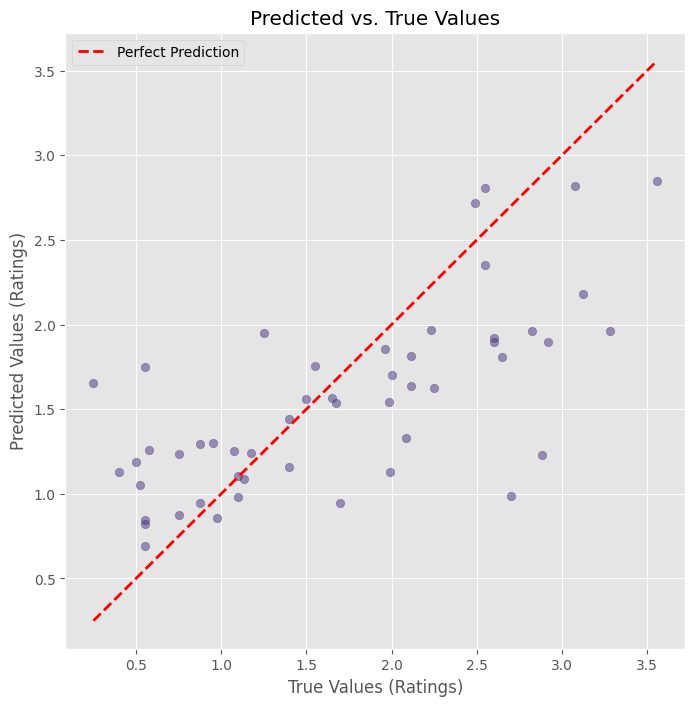


--- Classification Evaluation (Decision Threshold = 2.1) ---

--- Binary Classification Metrics (Scenario: THRESHOLD = 2.1) ---
--- Positive Class: Rejected (1) ---
-----------------------------------------------------------------
ROC AUC:                       0.8956
F1-Score (for Rejected class):   0.8462
Accuracy:                      0.7647
Balanced Accuracy:             0.6667
Precision (for Rejected class):  0.7333
Recall (Sensitivity):            1.0000   (33 / 33 Total Rejects)
-----------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

Accepted (0)       1.00      0.33      0.50        18
Rejected (1)       0.73      1.00      0.85        33

    accuracy                           0.76        51
   macro avg       0.87      0.67      0.67        51
weighted avg       0.83      0.76      0.72        51



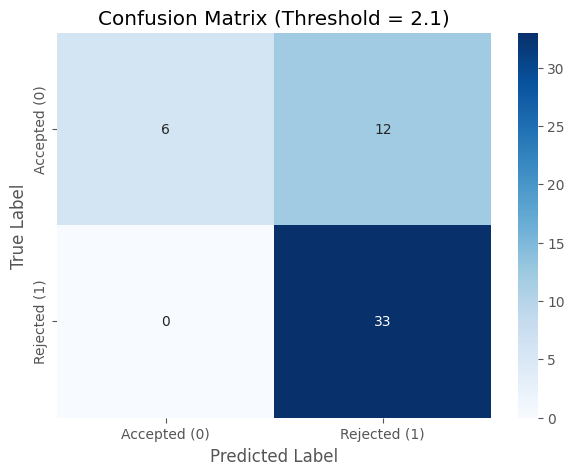

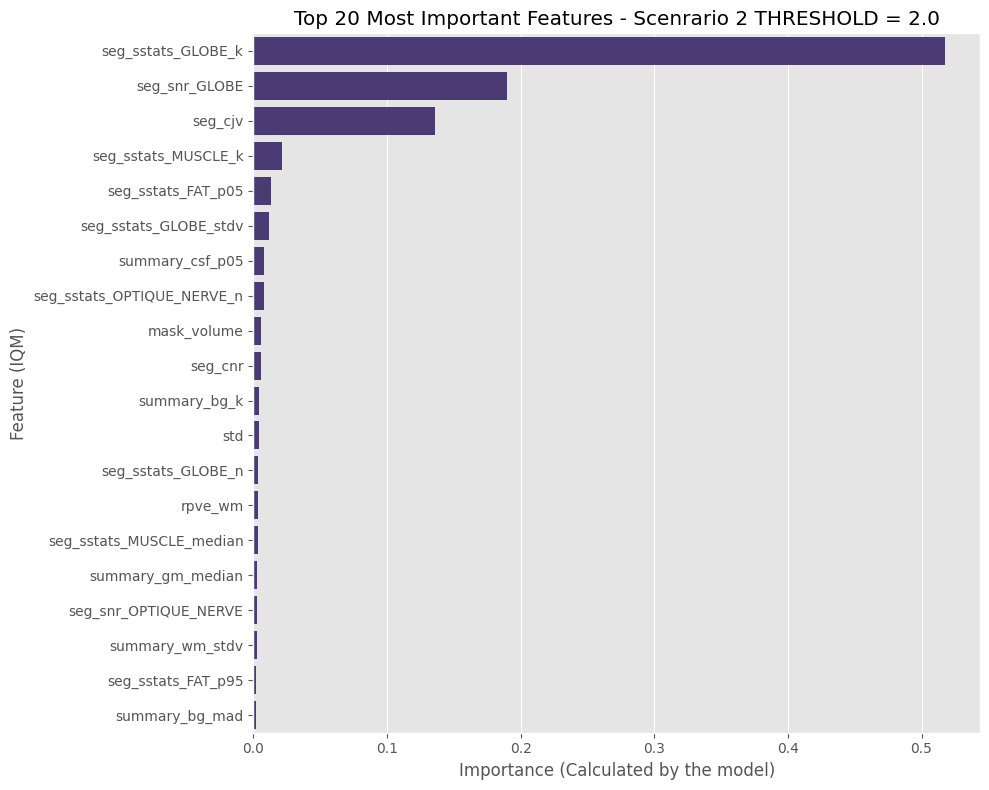

Cell 8: Evaluation for Scenrario 2 THRESHOLD = 2.0 complete.


In [8]:
# Cell 8: Model Prediction and Evaluation (Regression + Classification)
# This cell performs comprehensive evaluation of the trained regression model.
# It first assesses regression performance and then binarizes predictions
# using a defined threshold to evaluate classification performance.

# Proceed with evaluation only if a best model exists and test data is available and not empty.
if best_model and not X_test_scaled.empty and y_test is not None:
    # --- PART 1: REGRESSION EVALUATION ---
    # Predict continuous values for the test set using the best model.
    y_pred_test = best_model.predict(X_test_scaled)

    # Calculate standard regression metrics.
    r2 = r2_score(y_test, y_pred_test)          # R-squared (coefficient of determination)
    mse = mean_squared_error(y_test, y_pred_test) # Mean Squared Error
    rmse = np.sqrt(mse)                         # Root Mean Squared Error
    mae = mean_absolute_error(y_test, y_pred_test) # Mean Absolute Error

    print(f"\n--- Regression Metrics ({scenario_name}) ---")
    print(f"R-squared (R2):                 {r2:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE):      {mae:.4f}")

    # --- Plot: Predicted vs. True Values ---
    # This scatter plot visually compares the model's predictions against the actual values.
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred_test, alpha=0.5) # Plot true vs. predicted values
    # Plot a perfect prediction line (y=x) for reference.
    perfect_line = [min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max())]
    plt.plot(perfect_line, perfect_line, 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel("True Values (Ratings)"); plt.ylabel("Predicted Values (Ratings)")
    plt.title("Predicted vs. True Values"); plt.legend(); plt.grid(True)
    plt.show()

    # --- PART 2: CLASSIFICATION PERFORMANCE EVALUATION ---
    # This section treats the regression problem as a classification problem by binarizing
    # the continuous predictions based on the `EVALUATION_THRESHOLD`.
    print("\n" + "="*80)
    print(f"--- Classification Evaluation (Decision Threshold = {EVALUATION_THRESHOLD}) ---")
    print("="*80)

    # Binarize the true ratings: if rating <= threshold, it's "Rejected" (class 1); otherwise "Accepted" (class 0).
    y_test_binary = (y_test <= EVALUATION_THRESHOLD).astype(int)
    # Binarize the regression predictions using the same logic.
    y_pred_binary = (y_pred_test <= EVALUATION_THRESHOLD).astype(int)

    # Calculate standard classification metrics based on the binarized values.
    accuracy = accuracy_score(y_test_binary, y_pred_binary)
    balanced_acc = balanced_accuracy_score(y_test_binary, y_pred_binary)
    # Precision and Recall are calculated for the positive class (Rejected, which is 1).
    precision = precision_score(y_test_binary, y_pred_binary, pos_label=1, zero_division=0)
    recall = recall_score(y_test_binary, y_pred_binary, pos_label=1, zero_division=0) # Recall is also known as Sensitivity
    f1 = f1_score(y_test_binary, y_pred_binary, pos_label=1, zero_division=0)

    try:
        # For ROC AUC, we use the continuous predicted scores.
        # IMPORTANT: Since LOW rating scores correspond to the "Rejected" (positive) class (1),
        # we need to use `-y_pred_test` for `roc_auc_score` if the positive class is associated with lower scores.
        # This ensures that higher scores from `-y_pred_test` correspond to the positive class.
        roc_auc = roc_auc_score(y_test_binary, -y_pred_test)
    except ValueError as e:
        print(f"Warning: Could not calculate ROC AUC. {e}")
        roc_auc = float('nan') # Set to NaN if calculation fails (e.g., only one class present)

    # Calculate confusion matrix for detailed error analysis.
    cm = confusion_matrix(y_test_binary, y_pred_binary)

    # Extract true positives for the 'Rejected' class (class 1).
    if cm.shape == (2, 2): # Ensure it's a 2x2 matrix before accessing elements
        true_positives_rejects = cm[1, 1]
        total_actual_rejects = cm[1, 0] + cm[1, 1]
    else: # Handle cases where only one class is present in y_test_binary
        true_positives_rejects = 0
        total_actual_rejects = np.sum(y_test_binary == 1) # Total count of actual 'Rejected' instances

    # Display classification metrics.
    print(f"\n--- Binary Classification Metrics (Scenario: THRESHOLD = {EVALUATION_THRESHOLD}) ---")
    print(f"--- Positive Class: Rejected (1) ---")
    print("-" * 65)
    print(f"ROC AUC:                       {roc_auc:.4f}")
    print(f"F1-Score (for Rejected class):   {f1:.4f}")
    print(f"Accuracy:                      {accuracy:.4f}")
    print(f"Balanced Accuracy:             {balanced_acc:.4f}")
    print(f"Precision (for Rejected class):  {precision:.4f}")
    print(f"Recall (Sensitivity):            {recall:.4f}   ({true_positives_rejects} / {total_actual_rejects} Total Rejects)")
    print("-" * 65)

    # Print the full classification report.
    target_names = ['Accepted (0)', 'Rejected (1)'] # Define labels for the report and plots
    print("\nClassification Report:")
    print(classification_report(y_test_binary, y_pred_binary, target_names=target_names, zero_division=0))

    # --- Plot Confusion Matrix ---
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix (Threshold = {EVALUATION_THRESHOLD})')
    plt.xlabel('Predicted Label'); plt.ylabel('True Label')
    plt.show()

    # --- Feature Importance Plot ---
    # Plot feature importances if the model provides them (e.g., RandomForestRegressor).
    if hasattr(best_model, 'feature_importances_') and 'numeric_features_final' in locals() and numeric_features_final:
        # Check if the number of importances matches the number of features.
        if len(numeric_features_final) == len(best_model.feature_importances_):
            importances = best_model.feature_importances_
            # Create a DataFrame for easy sorting and plotting of importances.
            ft_imp_df = pd.DataFrame({'feature': numeric_features_final, 'importance': importances})
            ft_imp_df = ft_imp_df.sort_values(by='importance', ascending=False) # Sort in descending order

            plt.figure(figsize=(10, 8))
            sns.barplot(x='importance', y='feature', data=ft_imp_df.head(20)) # Plot the top 20 most important features
            plt.title(f'Top 20 Most Important Features - {scenario_name}')
            plt.xlabel('Importance (Calculated by the model)')
            plt.ylabel('Feature (IQM)')
            plt.tight_layout() # Adjust layout to prevent labels from overlapping
            plt.show()
        else:
            print("   WARNING: Mismatch between number of features and feature importances. Cannot plot feature importances.")
    elif not hasattr(best_model, 'feature_importances_'):
        print(f"   NOTE: Model '{MODEL_CHOICE}' does not have 'feature_importances_' attribute (or equivalent for importance).")

else:
    print("Skipping evaluation: Model not trained or test data not available/empty.")

print(f"Cell 8: Evaluation for {scenario_name} complete.")